In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/permanent/RECHERCHE3
%ls

/gdrive/My Drive/permanent/RECHERCHE3
ddqn_lib/  Euler.zip  Hamilton/     model_1.h5  popup_lib/
Euler/     GCN/       Hamilton.zip  model_2.h5  popup_lib.zip


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from GCN.frontier_generator import Frontier
from GCN.learn import Agent_frontier


## Création des données

Le générateur de frontière peut être utiliser de deux manières:

1/ Quand `vec_x` et `vec_y` sont deux vecteurs de taille `N` (représentant des abscisses et des ordonnées): 

        frontier.compute(vec_x, vec_y, batch_size=B)

va calculer `B` fonctions aléatoires `f_0,...,f_B-1` et renvoie 

    f_0(vec_x,vec_y)
    f_1(vec_x,vec_y)
    .
    .
    .
    f_B-1(vec_x,vec_y)



2/ Quand `mat_x` et `mat_y` sont udes matrice de taille `(B,N)`. Alors

        frontier.compute(mat_x, mat_y, batch_size=None)

va calculer `B` fonctions aléatoires `f_0,...,f_B-1` et renvoie 

    f_0(mat_x[0,:],mat_y[0,:])
    f_1(mat_x[1,:],mat_y[1,:])
    .
    .
    .
    f_B-1(mat_x[B-1,:],mat_y[B-1,:])


La manière 1 est utilisée ci-dessous car on travaille sur un maillage toujours identique. 

Pour le GCN il faudra utiliser la manière 2. 



### Variation sur le type d'image

In [9]:
def show_image(kind,frontier_kind=Frontier.frontier_smooth):
    frontier=Frontier(kind=kind,frontier_kind=frontier_kind)

    nb=100
    batch_size=25
    a = np.linspace(0., 1, nb,dtype=np.float32)
    aa, bb = tf.meshgrid(a, a)
    aaa = tf.reshape(aa,[-1])
    bbb = tf.reshape(bb,[-1])

    X,Y=frontier.compute(aaa, bbb, batch_size)

    X=tf.reshape(X,[batch_size,nb,nb])
    Y=tf.reshape(Y,[batch_size,nb,nb])
   

    fig, axs = plt.subplots(5, 5, figsize=(12, 12))
    axs = axs.reshape(-1)

    for i,ax in enumerate(axs):
        ax.pcolormesh(aa,bb,X[i,:,:], cmap="jet",shading="gouraud")
        ax.contour(aa,bb,Y[i,:,:], colors='k')
        ax.axis("off")

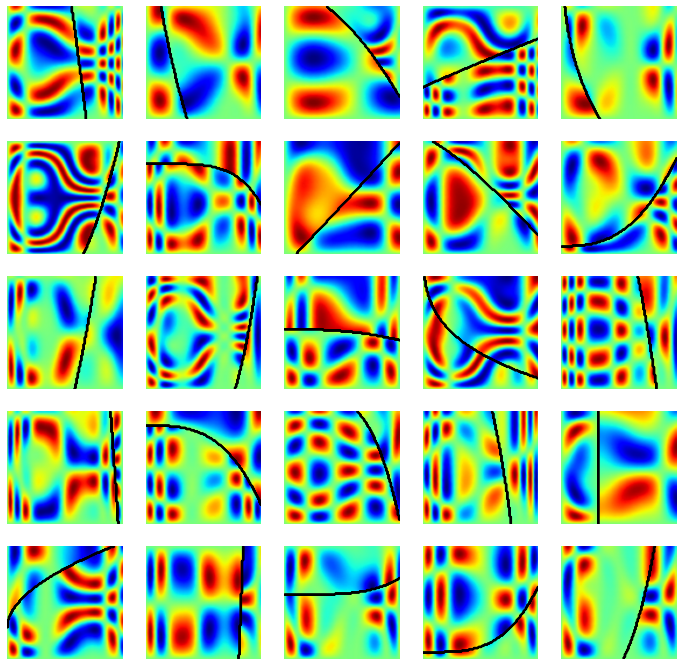

In [5]:
show_image(Frontier.kind_iles)

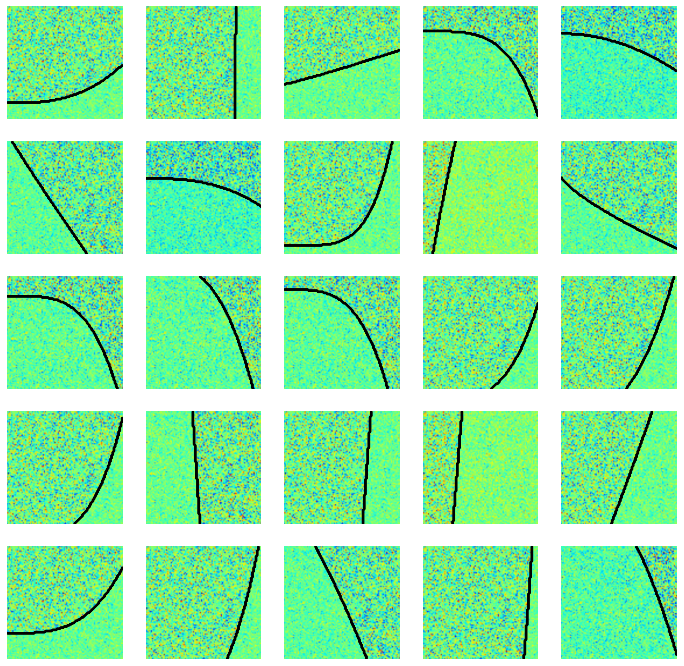

In [6]:
show_image(Frontier.kind_gaussian_noise)

### Problème difficile

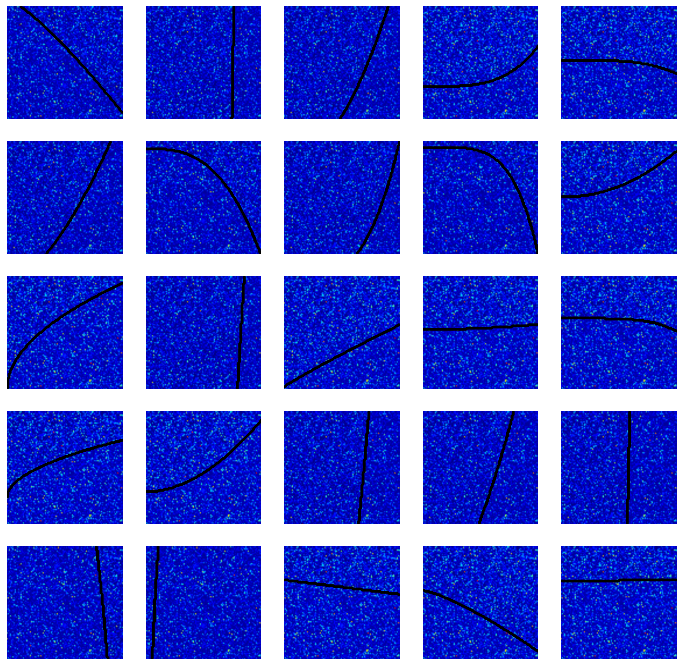

In [7]:
show_image(Frontier.kind_gamma_noise)

Il s'agit de deux bruit gamma aillant même espérance et même variance. Voici les histogrammes

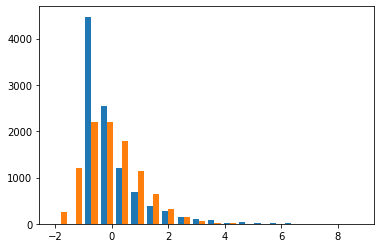

In [36]:
def test_gamma():
    
    frontier=Frontier()
    frontier.check_histo_of_noise_gamma()

test_gamma()

Le problème n'est pas insoluble. Par exemple, avec un bon seuillage: 

In [45]:

def show_image_2():
    frontier=Frontier(kind=Frontier.kind_gamma_noise)

    nb=100
    batch_size=25
    a = np.linspace(0., 1, nb,dtype=np.float32)
    aa, bb = tf.meshgrid(a, a)
    aaa = tf.reshape(aa,[-1])
    bbb = tf.reshape(bb,[-1])

    X,Y=frontier.compute(aaa, bbb, batch_size)

    X=tf.reshape(X,[batch_size,nb,nb])
    Y=tf.reshape(Y,[batch_size,nb,nb])
   

    fig, axs = plt.subplots(5, 5, figsize=(12, 12))
    axs = axs.reshape(-1)

    for i,ax in enumerate(axs):
        ax.pcolormesh(aa,bb,X[i,:,:]<-0.7, cmap="jet",shading="gouraud")
        ax.contour(aa,bb,Y[i,:,:], colors='k')
        ax.axis("off")

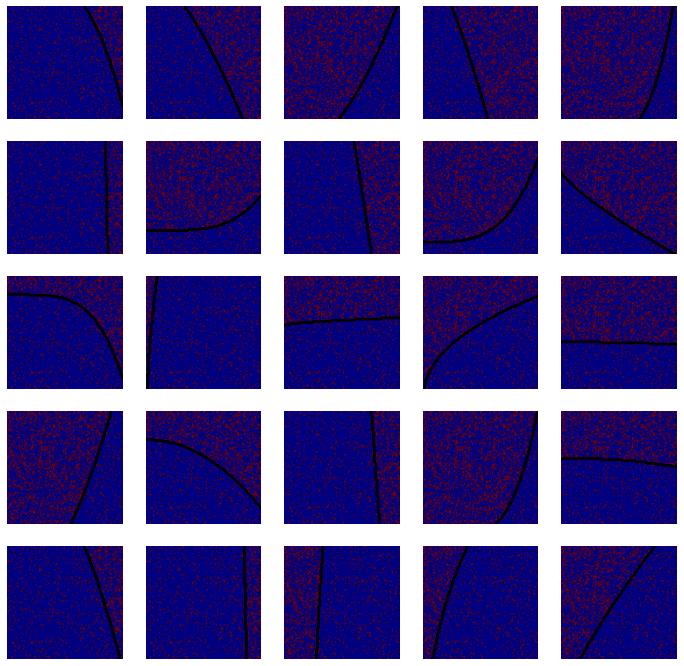

In [46]:
show_image_2()

### Problème trivial

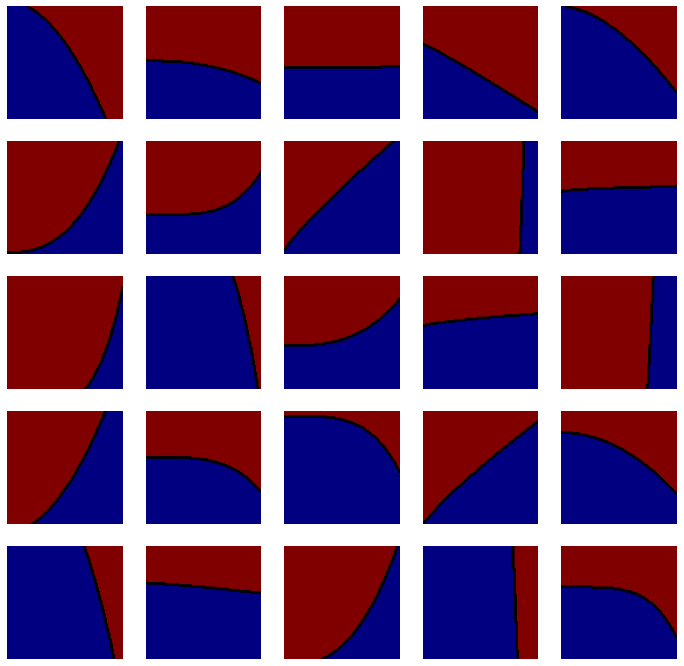

In [8]:
#pour le debug
show_image(Frontier.kind_trivial)

### Variation sur le type de frontière

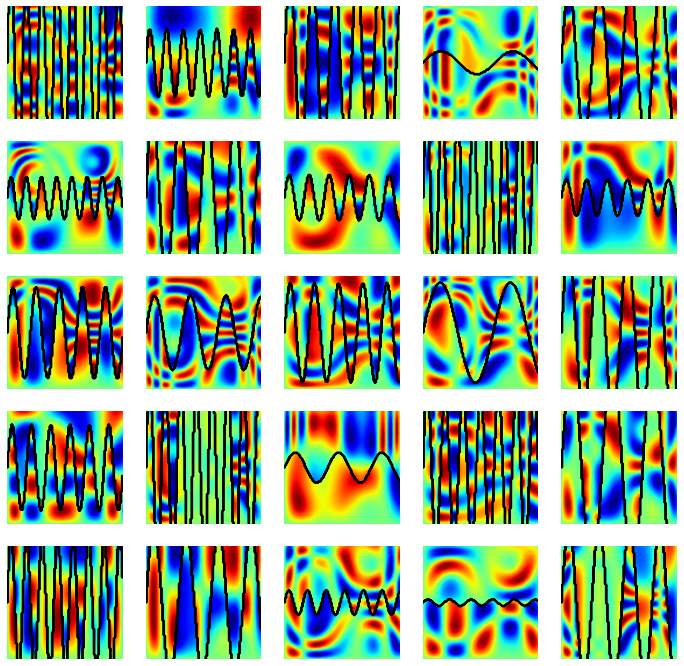

In [10]:
show_image(Frontier.kind_iles,Frontier.frontier_oscilating)

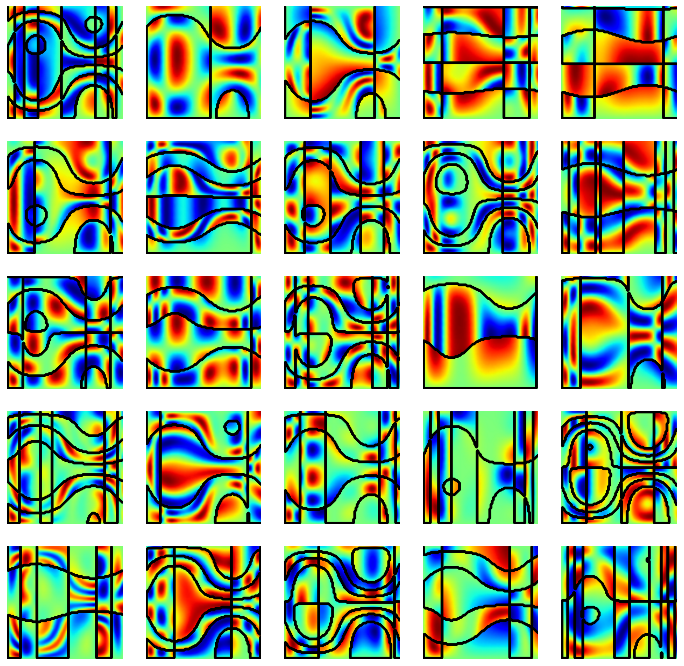

In [11]:
show_image(Frontier.kind_iles,Frontier.frontier_ile)

### Variation sur le smoothing

TODO: ajouter un smoothing qui lisse la discontinuité (plus ou moins). 

Avec un  smoothing important, l'apprentissage sera bien plus difficile: Le réseau de neurone ne devra pas détecter une simple discontinuité, mais plutôt une variation inhabituelle de la fonction. 


## Apprentissage

On va apprendre avec un Vnet sur maillage cartésien.

Voir [Ce TP](https://colab.research.google.com/drive/1C6AaGtPhAgeU1-5YK-w2ahc6_fT2KA7V?usp=sharing).

Je pense que, même avec le GCN c'est intéressant d'utiliser la loss dice. 


### Frontière lisse

In [27]:
def test_agent_train(kind,frontier_kind=Frontier.frontier_smooth,minutes=0.5):
    frontier=Frontier(kind=kind,frontier_kind=frontier_kind)
    #attention au paramètres. ex: batch_size=128 ça apprend mal. 
    agent = Agent_frontier(frontier,image_size=(100,100,1),batch_size=20)
    agent.train(minutes)

    X,Y=agent.generate_data()
    Y_pred=agent.best_model(X)
    fig, axs = plt.subplots(5, 3, figsize=(6, 10))
    for i in range(5):
        axs[i, 0].imshow(X[i, :, :, 0], cmap="jet", interpolation=None)
        axs[i, 1].imshow(Y_pred[i, :, :, 0], cmap="gray", interpolation=None)
        axs[i, 2].imshow(Y[i, :, :, 0], cmap="gray", interpolation=None)

        axs[i, 0].axis("off")
        axs[i, 1].axis("off")
        axs[i, 2].axis("off")

    axs[0,0].set_title("X")
    axs[0,1].set_title("Y_pred")
    axs[0,2].set_title("Y")


    plt.show()

left[0].shape= (None, 100, 100, 2)
left[1].shape= (None, 50, 50, 4)
central.shape= (None, 25, 25, 8)
right[1].shape= (None, 50, 50, 4)
right[0].shape= (None, 100, 100, 2)
⤥:93.5351⤥:87.0896⤥:69.2076⤥:48.2604⤥:31.1439⤥:19.6725⤥:11.8660.⤥:7.9806.⤥:6.3399..⤥:5.7844⤥:5.1887.....⤥:4.4839⤥:3.3258........⤥:2.6566...................⤥:2.5652.......................⤥:2.0461......................................⤥:2.0095...⤥:1.7641....WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


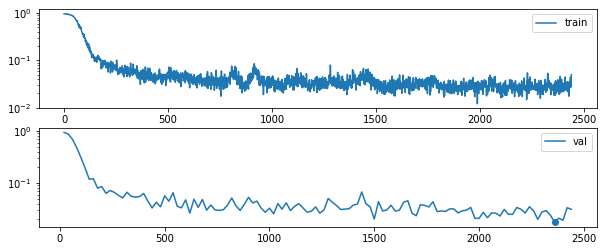

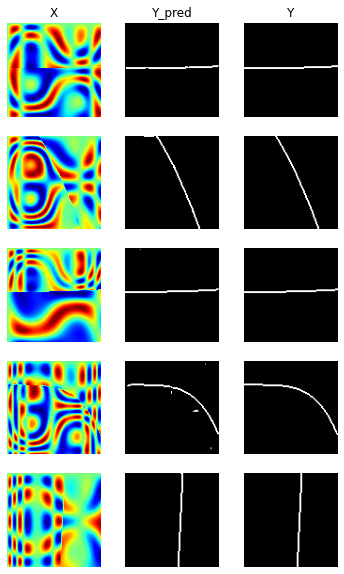

In [28]:
test_agent_train(Frontier.kind_iles)

left[0].shape= (None, 100, 100, 2)
left[1].shape= (None, 50, 50, 4)
central.shape= (None, 25, 25, 8)
right[1].shape= (None, 50, 50, 4)
right[0].shape= (None, 100, 100, 2)
⤥:93.8428⤥:86.2281⤥:67.4929⤥:63.1545⤥:48.3081⤥:42.7445⤥:37.3452⤥:34.2611..⤥:30.5796.⤥:30.1761.⤥:30.0748⤥:27.7803..⤥:24.9572.........⤥:24.8130....⤥:23.8612.........⤥:22.6375..⤥:22.2092.⤥:22.0937...⤥:21.8379.......⤥:20.6352.................⤥:19.6446..⤥:19.4016.............⤥:18.2667............................WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


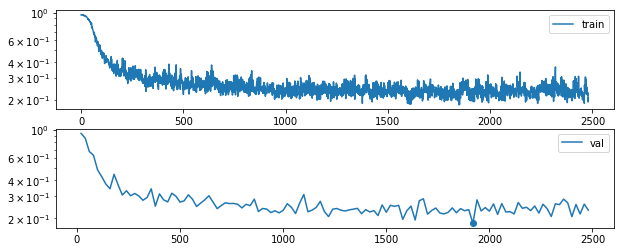

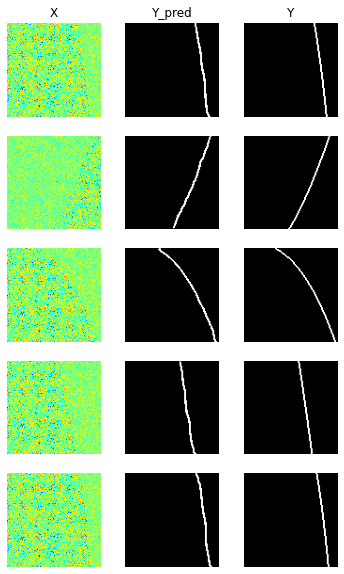

In [29]:
#parfois ça apprend pas... 
test_agent_train(Frontier.kind_gaussian_noise)

left[0].shape= (None, 100, 100, 2)
left[1].shape= (None, 50, 50, 4)
central.shape= (None, 25, 25, 8)
right[1].shape= (None, 50, 50, 4)
right[0].shape= (None, 100, 100, 2)
⤥:96.1522.⤥:95.9936.⤥:95.9089⤥:95.4725..⤥:95.1359⤥:94.8713..⤥:94.6871..............................⤥:94.6358.........⤥:94.1360..................................................WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


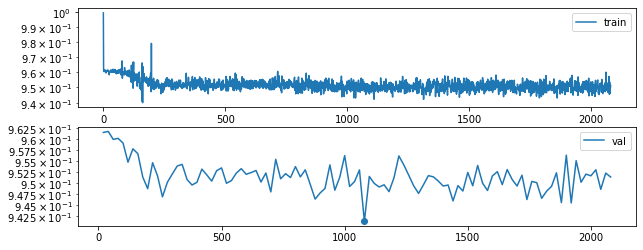

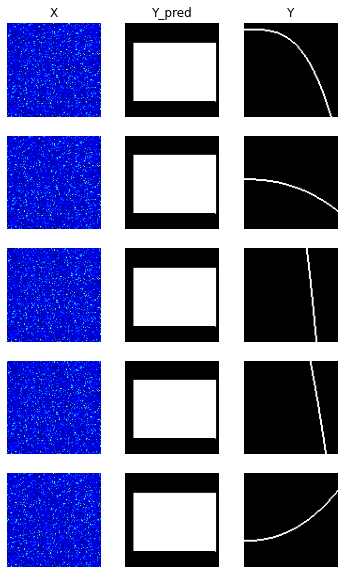

In [30]:
#là ça ne fonctionne jamais (ça pourrait)
test_agent_train(Frontier.kind_gamma_noise)

### Autre frontières

left[0].shape= (None, 100, 100, 2)
left[1].shape= (None, 50, 50, 4)
central.shape= (None, 25, 25, 8)
right[1].shape= (None, 50, 50, 4)
right[0].shape= (None, 100, 100, 2)
⤥:71.4799⤥:62.7771⤥:29.3588⤥:13.9617⤥:10.9025⤥:6.6662⤥:6.1638⤥:5.7831...⤥:4.8171.⤥:3.8378...⤥:3.5401⤥:3.4868..⤥:3.4747.....⤥:3.1470..⤥:2.7879......⤥:2.6263..............⤥:2.5275⤥:2.5088...⤥:2.3373⤥:2.1781..........⤥:2.1653.........⤥:1.7235.............⤥:1.7163.......⤥:1.6846..................WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


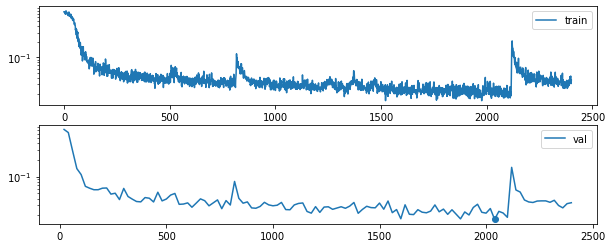

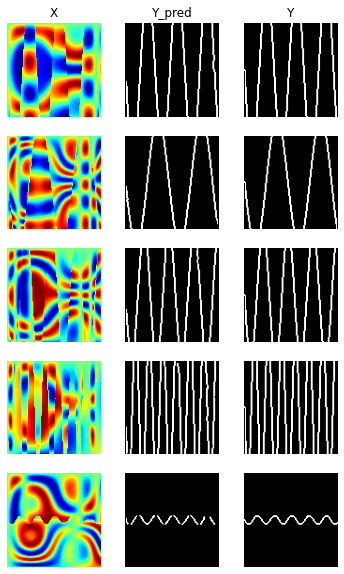

In [31]:
#ici, ça ne fonctionne pas en résolution grossière (40,40)
test_agent_train(Frontier.kind_iles,frontier_kind=Frontier.frontier_oscilating)

left[0].shape= (None, 100, 100, 2)
left[1].shape= (None, 50, 50, 4)
central.shape= (None, 25, 25, 8)
right[1].shape= (None, 50, 50, 4)
right[0].shape= (None, 100, 100, 2)
⤥:72.7362...⤥:72.4785....⤥:71.7003.⤥:71.6068.⤥:69.0674................................................................................................................WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


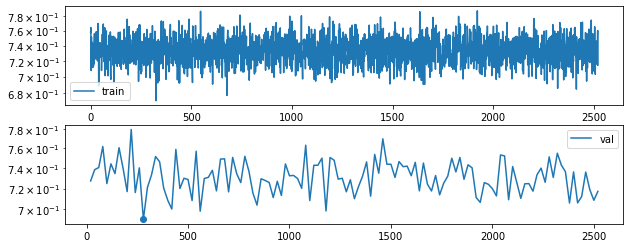

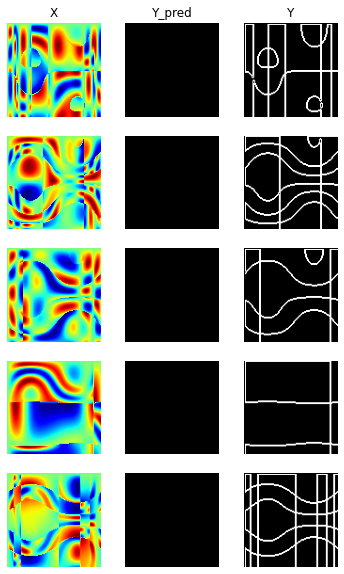

In [33]:
#trop complexe
test_agent_train(Frontier.kind_iles,frontier_kind=Frontier.frontier_ile)

left[0].shape= (None, 100, 100, 2)
left[1].shape= (None, 50, 50, 4)
central.shape= (None, 25, 25, 8)
right[1].shape= (None, 50, 50, 4)
right[0].shape= (None, 100, 100, 2)
⤥:71.1011⤥:64.7286⤥:43.8318⤥:15.5292⤥:3.9019⤥:2.1269⤥:1.2185.⤥:0.8064..⤥:0.4326....⤥:0.2627.........⤥:0.2553......⤥:0.2050..........⤥:0.1464............⤥:0.1380.....................⤥:0.1021..............................⤥:0.0859...............WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


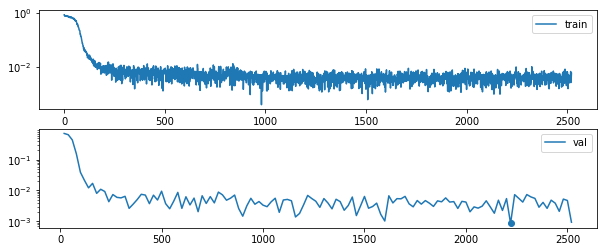

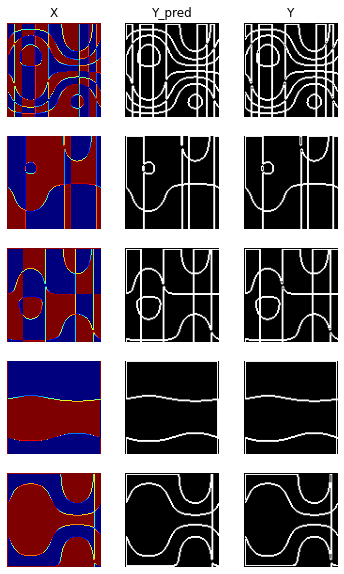

In [34]:
test_agent_train(Frontier.kind_trivial,frontier_kind=Frontier.frontier_ile)

left[0].shape= (None, 100, 100, 2)
left[1].shape= (None, 50, 50, 4)
central.shape= (None, 25, 25, 8)
right[1].shape= (None, 50, 50, 4)
right[0].shape= (None, 100, 100, 2)
⤥:72.1873⤥:71.9615⤥:71.7119⤥:69.6557....................................................................⤥:69.3569......................................................WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


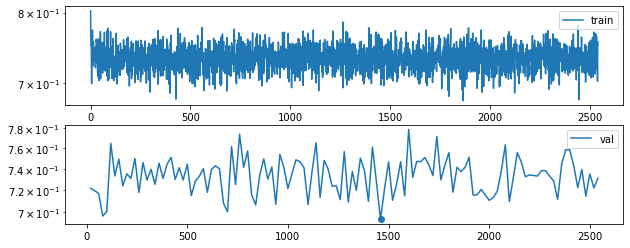

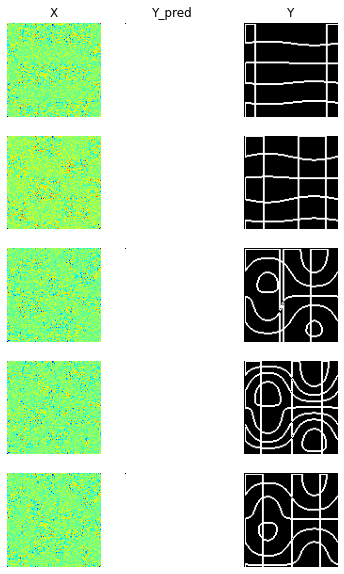

In [35]:
test_agent_train(Frontier.kind_gaussian_noise,frontier_kind=Frontier.frontier_ile)